This project aims to leverage toy examples to illustrate how to build linear model, deep neural networks, convolutional nueral networds as well as recurrent neural networks by [Tensorflow](www.tensorflow.org). The dataset is famous handwritten digits dataset, namely [MNIST](http://yann.lecun.com/exdb/mnist/).

In [62]:
#Import required packages
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#Load MNIST dataset
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [63]:
print(mnist.train.images.shape)

(55000, 784)


In [19]:
print(mnist.test.images.shape)

(10000, 784)


There are 55000 items of training data, and 10000 items of testing data. Let's take a look at the samples

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


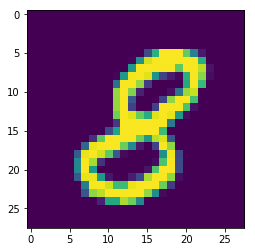

In [4]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))
print(mnist.train.labels[5])

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


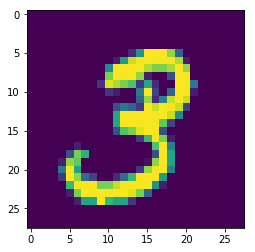

In [5]:
plt.imshow(mnist.train.images[1].reshape([28, 28]))
print(mnist.train.labels[1])

In [64]:
n_tr = mnist.train.images.shape[0]# number of training samples
n_ts = mnist.test.images.shape[0]#number of testing samples
n_pixel = mnist.train.images.shape[1]

## 1、Choose Right Optimizer 

Apart from batch gradient descending method, which tends to be slow an memory-consuming, there are several other gradient descending methods which can make train process fast. For example, SGD optimizer feed the model a small number of samples each time during the iteration, and Adam optimizer can adjust itself to accelerate learning. For more information, we can join Andrew Ng.'s deep learning course: https://www.coursera.org/learn/deep-neural-network . 

### 1. 1 Adam Optimizer

In [90]:
#Create weights
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initial, name='weights')

#Create biases
def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial, name='biases')

In [91]:
#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [92]:
def conv_relu_pool(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = weight_variable(kernel_shape)
    # Create variable named "biases".
    biases = bias_variable(bias_shape)
    conv = conv2d(input, weights)
    relu = tf.nn.relu(conv + biases)
    pool = max_pool_2x2(relu)
    return pool

In [93]:
def cnnLayer(x, keep_prob):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.name_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

In [94]:
def optimize_method(method, cross_entropy):
    if method == 'adam':
        train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)
    elif method == 'sgd':
        #Gradient Descending Optimizer
        global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
        starter_learning_rate = 0.0005
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.96, staircase=True)
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
        #train_step = tf.train.GradientDescentOptimizer(0.0005).minimize(cross_entropy)
    elif method == 'rmsprop':
        train_step = tf.train.RMSPropOptimizer(learning_rate=0.0005, decay=0.95).minimize(cross_entropy)
    return train_step

In [70]:
graph_cnn = tf.Graph()
with graph_cnn.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))

In [71]:
with graph_cnn.as_default() as g:
    #Adam Optimizer
    train_step = optimize_method('adam', cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [72]:
e_pochs = 10
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
                
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss: 146.185
Loss: 7.6896
Loss: 3.53305
Loss: 4.07624
Loss: 2.37297
Loss: 3.46475
Loss: 0.198322
Loss: 1.26465
Loss: 0.120211
Loss: 0.106492
Loss: 0.0613034
Loss: 0.509934
Loss: 0.34047
Loss: 0.182606
Loss: 0.310183
Loss: 0.365764
Loss: 0.739669
Loss: 0.118325
Loss: 0.0226946
Loss: 0.719844
Testing Accuracy： 0.9989


### 1.2 SGD Optimizer

In [88]:
graph_cnn2 = tf.Graph()
with graph_cnn2.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))

In [89]:
with graph_cnn2.as_default() as g:
    #Sgd Optimizer
    train_step = optimize_method('sgd', cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [90]:
e_pochs = 30
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn2) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
                
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss: 147.356
Loss: 146.352
Loss: 20.7495
Loss: 6.21662
Loss: 3.75816
Loss: 4.20633
Loss: 3.72263
Loss: 2.21412
Loss: 1.09152
Loss: 4.7276
Loss: 4.4408
Loss: 0.959433
Loss: 0.727336
Loss: 0.384447
Loss: 0.942069
Loss: 0.709076
Loss: 0.394239
Loss: 0.118397
Loss: 0.620972
Loss: 0.394562
Loss: 1.19378
Loss: 1.96052
Loss: 0.930474
Loss: 0.0656988
Loss: 2.3838
Loss: 0.616717
Loss: 0.360548
Loss: 0.121471
Loss: 0.131276
Loss: 0.18342
Loss: 0.114645
Loss: 0.351043
Loss: 0.678493
Loss: 0.0684983
Loss: 0.262424
Loss: 0.254962
Loss: 0.334311
Loss: 0.514812
Loss: 0.227101
Loss: 0.33369
Loss: 0.13883
Loss: 0.360746
Loss: 0.547493
Loss: 0.328938
Loss: 0.285729
Loss: 0.610307
Loss: 0.0187569
Loss: 0.0537181
Loss: 0.310639
Loss: 0.206579
Loss: 0.140233
Loss: 0.24201
Loss: 2.10571
Loss: 0.41685
Loss: 0.150397
Loss: 0.0848864
Loss: 0.163611
Loss: 0.163637
Loss: 0.0790276
Loss: 0.393038
Testing Accuracy： 0.9984


### 1.3 RMSProp Optimizer

In [95]:
graph_cnn3 = tf.Graph()
with graph_cnn3.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #RMSprop Optimizer
    train_step = optimize_method('rmsprop', cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [99]:
e_pochs = 5
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn3) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
                
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss: 147.333
Loss: 6.35991
Loss: 0.734154
Loss: 0.775099
Loss: 0.213127
Loss: 0.521301
Loss: 0.184838
Loss: 0.293952
Loss: 0.188002
Loss: 0.0245486
Testing Accuracy： 0.9947


### 1.4 Momentum

In [30]:
graph_cnn4 = tf.Graph()
with graph_cnn4.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    
    #Decaying learning rate
    #global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    #starter_learning_rate = 0.001
    #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 1000, 0.96, staircase=True)
    #Get the gradient
    #tvars = tf.trainable_variables()
    #grads, _ = tf.clip_by_global_norm(tf.gradients(cross_entropy, tvars), 5)
    #Clip the gradient
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    #train_step = optimizer.apply_gradients(
        #zip(grads, tvars),
        #global_step=global_step)
    #Define accuracy
    train_step = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [31]:
e_pochs = 22
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn4) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                l, acc = sess.run([cross_entropy, accuracy], feed_dict=feed_dict)
                print('Loss:{:.5f}'.format(l) , 'Accuracy:{:.5f}'.format(acc))
                
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss:147.41211 Accuracy:0.10938
Loss:21.90355 Accuracy:0.93750
Loss:7.92793 Accuracy:0.96875
Loss:1.93566 Accuracy:1.00000
Loss:6.34537 Accuracy:0.98438
Loss:0.72142 Accuracy:1.00000
Loss:1.92262 Accuracy:1.00000
Loss:1.01777 Accuracy:0.98438
Loss:4.03196 Accuracy:0.98438
Loss:5.12439 Accuracy:0.96875
Loss:1.94573 Accuracy:0.98438
Loss:2.04563 Accuracy:0.98438
Loss:1.33935 Accuracy:0.98438
Loss:2.25252 Accuracy:0.98438
Loss:0.06013 Accuracy:1.00000
Loss:0.82740 Accuracy:0.98438
Loss:0.31411 Accuracy:1.00000
Loss:0.12469 Accuracy:1.00000
Loss:1.67208 Accuracy:0.98438
Loss:0.88636 Accuracy:1.00000
Loss:0.48820 Accuracy:1.00000
Loss:0.31426 Accuracy:1.00000
Loss:0.80277 Accuracy:1.00000
Loss:0.29741 Accuracy:1.00000
Loss:0.67373 Accuracy:1.00000
Loss:0.10931 Accuracy:1.00000
Loss:0.64140 Accuracy:1.00000
Loss:1.32997 Accuracy:1.00000
Loss:0.06049 Accuracy:1.00000
Loss:0.52272 Accuracy:1.00000
Loss:6.59680 Accuracy:0.98438
Loss:0.02583 Accuracy:1.00000
Loss:0.33761 Accuracy:1.00000
Loss:0.

It seems momentum optimizer works well here. Note, **sometimes the predicted values approximate 0, and log(0) will be nan**, in order to avoid this case, we can use ``` tf.clip_by_value(y_predict, 1e-10, 1.0) ``` to make the predicted value locate in a range.

## 2. Use Xavier Initializer

In order to improve the performance of CNN, we can replace normal initialization with Xavier initialization.

In [34]:
initializer = tf.contrib.layers.xavier_initializer_conv2d()
#Create weights of random distributed
def weight_variable(shape):
  return tf.Variable(initializer(shape), name='weights')

#Create biases
def bias_variable(shape):
  return tf.Variable(initializer(shape), name='biases')

#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [35]:
def cnnLayer2(x, keep_prob):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [3, 3, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [3, 3, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.name_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

In [39]:
cnn_xavier = tf.Graph()
with cnn_xavier.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer2(x, keep_prob)
    #Note, in order to prevent nan appear, we 
    #need to control the range of predicted values
    y = tf.clip_by_value(y, 1e-10, 1.0)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))

    train_step = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [41]:
e_pochs = 20
batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=cnn_xavier) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    #Run on GTX960 GPU
    for _ in range(e_pochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                l, acc = sess.run([cross_entropy, accuracy], feed_dict=feed_dict)
                print('Loss:{:.5f}'.format(l) , 'Accuracy:{:.5f}'.format(acc))
                
    count = 0  
    #Due to the limited GPU memory, we have to split the testing data into batches
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

Loss:148.62834 Accuracy:0.09375
Loss:9.23215 Accuracy:0.93750
Loss:9.23427 Accuracy:0.96875
Loss:2.13606 Accuracy:1.00000
Loss:2.63412 Accuracy:0.98438
Loss:3.77895 Accuracy:0.96875
Loss:4.23011 Accuracy:0.98438
Loss:2.52950 Accuracy:0.98438
Loss:4.96692 Accuracy:0.95312
Loss:0.38285 Accuracy:1.00000
Loss:0.58528 Accuracy:1.00000
Loss:0.35823 Accuracy:1.00000
Loss:3.13176 Accuracy:0.98438
Loss:0.29653 Accuracy:1.00000
Loss:1.16656 Accuracy:0.98438
Loss:3.52067 Accuracy:0.98438
Loss:2.22508 Accuracy:0.98438
Loss:0.07129 Accuracy:1.00000
Loss:0.18338 Accuracy:1.00000
Loss:0.38540 Accuracy:1.00000
Loss:1.61193 Accuracy:0.98438
Loss:0.55105 Accuracy:1.00000
Loss:0.08754 Accuracy:1.00000
Loss:0.69087 Accuracy:1.00000
Loss:0.01934 Accuracy:1.00000
Loss:0.31349 Accuracy:1.00000
Loss:0.32467 Accuracy:1.00000
Loss:0.42119 Accuracy:1.00000
Loss:0.09420 Accuracy:1.00000
Loss:0.08421 Accuracy:1.00000
Loss:0.05759 Accuracy:1.00000
Loss:0.24962 Accuracy:1.00000
Loss:1.48187 Accuracy:0.98438
Loss:0.0

It seems Xavier initialization makes the training converge faster and more accurate.

## 3. Gradient Clipping and Learning Rate decaying

Sometimes if there are too many layers, or the weights are not well initialized, or the learning ratio is not small enough, we may encounter gradient explosion or vanish. In order to avoid such case, we can use gradient clip.

### 3.1 Single Layer Model

In [42]:
from tensorflow.contrib import rnn
# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
learning_rate = 0.00002

In [43]:
def rnnLayer(x):
    '''
    Create a Rnn layer
    Treat each image as a series of vectors
    the time step is n_step
    the size of input vector is n_input
    '''
    # Transform X into series
    # Reshape data to get 28 seq of 28 elements
    x = tf.reshape(x, (-1, n_steps, n_input))
    x = tf.transpose(x, [1, 0, 2])
    # (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # (batch_size, n_input)
    x = tf.split(x, n_steps, 0)
    with tf.variable_scope("rnn_lstm"):
        # Define a lstm cell with tensorflow
        lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
        with tf.variable_scope('rnn_layer'):
            # Get lstm cell output
            outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
            # Linear activation, using rnn inner loop last output
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    logits = tf.matmul(outputs[-1], weights) + biases
    return tf.nn.softmax(logits)

In [51]:
graph_rnn = tf.Graph()
with graph_rnn.as_default():
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_steps*n_input])
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    y = rnnLayer(x)
    # Define loss and optimizer
    cross_entropy = -tf.reduce_mean(y_* tf.log(y))
    
    cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    starter_learning_rate = 0.005
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cross_entropy, tvars),
                                      5)
    #Decaying the learning rate every 1000 steps
    learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 1000, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.apply_gradients(
        zip(grads, tvars),
        global_step=cur_step)
    #train_op = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [52]:
# Parameters
e_pochs = 20
batch_size = 64
num_steps = int(n_tr/batch_size)
display_step = 600
# Launch the graph
with tf.Session(graph=graph_rnn) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    # Keep training until reach max iterations
    for _ in range(e_pochs):
        for step in np.arange(num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
        
             # Run optimization op (backprop)
            _, loss, acc = sess.run([train_op, cross_entropy, accuracy], feed_dict={x: batch_x, y_: batch_y})
            if step % display_step == 0:
                # Calculate batch accuracy
                print('Loss:{:.5f}'.format(loss), "Training Accuracy= " + \
                      "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_data = mnist.test.images
    test_label = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y_: test_label}))

Loss:0.25427 Training Accuracy= 0.10938
Loss:0.02669 Training Accuracy= 0.93750
Loss:0.01500 Training Accuracy= 0.95312
Loss:0.00914 Training Accuracy= 0.98438
Loss:0.01127 Training Accuracy= 0.96875
Loss:0.00199 Training Accuracy= 0.98438
Loss:0.00157 Training Accuracy= 1.00000
Loss:0.00075 Training Accuracy= 1.00000
Loss:0.00660 Training Accuracy= 0.96875
Loss:0.00045 Training Accuracy= 1.00000
Loss:0.00411 Training Accuracy= 0.98438
Loss:0.00101 Training Accuracy= 1.00000
Loss:0.00190 Training Accuracy= 1.00000
Loss:0.00030 Training Accuracy= 1.00000
Loss:0.00138 Training Accuracy= 1.00000
Loss:0.00045 Training Accuracy= 1.00000
Loss:0.00758 Training Accuracy= 0.96875
Loss:0.00032 Training Accuracy= 1.00000
Loss:0.00075 Training Accuracy= 1.00000
Loss:0.00035 Training Accuracy= 1.00000
Loss:0.00094 Training Accuracy= 1.00000
Loss:0.00086 Training Accuracy= 1.00000
Loss:0.00013 Training Accuracy= 1.00000
Loss:0.00006 Training Accuracy= 1.00000
Loss:0.00017 Training Accuracy= 1.00000


### 3.2 Multi-layer Model

In this example, we create a two-layer LSTM neural network with dropout method to prevent against overfitting.

In [53]:
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
n_input = 28
n_steps = 28 # timesteps
layer_num = 2 #LSTM layer number
batch_size = 64

In [54]:
def lstm_cell(keep_prob):
    '''Create a basic lstm cell with dropout'''
    cell = rnn.BasicLSTMCell(n_hidden, forget_bias=0)
    cell = rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
    return cell

In [55]:
def multi_rnnLayer(x, keep_prob):
    # Transform X into series
    # Reshape data to get 28 seq of 28 elements
    x = tf.reshape(x, (-1, n_steps, n_input))
    # split input into 28 seqs with size(batch_size, input_size)
    x = tf.unstack(x, n_steps, 1)
    with tf.variable_scope("multi_rnn_lstm"):
        # Define a lstm cell with tensorflow
        cell = lstm_cell
        #Add dropout to prevent against overfitting
        #cell = rnn.DropoutWrapper(cell=cell(), input_keep_prob=1.0, output_keep_prob=keep_prob)
        #Create two layer LSTM network
        #Note cell() creates different cells each time, this is very important
        #DO NOT USE lstm_cell directly which will invoke parameter sharing problem
        mlstm_cell = rnn.MultiRNNCell([cell(keep_prob) for _ in range(layer_num)], state_is_tuple=True)
        with tf.variable_scope('multi_rnn_layer'):
            # Get lstm cell output, using dynamic rnn, the input is one tensor
            #outputs, states = tf.nn.dynamic_rnn(mlstm_cell, x, dtype=tf.float32)
            #if we use static rnn, we need to unrollthe graphs and the tensor slices
            #x must be a list of tensors
            outputs, states = rnn.static_rnn(mlstm_cell, x, dtype=tf.float32)
            #An alternative below
            #outputs = []
            #state = mlstm_cell.zero_state(batch_size,tf.float32)
            #for time_step in range(n_steps):
                #if time_step > 0: tf.get_variable_scope().reuse_variables()
                #cell_output, state = mlstm_cell(x[:, time_step, :], state)
                #outputs.append(cell_output)
        # Linear activation, using rnn inner loop last output
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    logits = tf.matmul(outputs[-1], weights) + biases
    return tf.nn.softmax(logits)

In [58]:
graph_multirnn = tf.Graph()
with graph_multirnn.as_default():
    # tf Graph input
    x = tf.placeholder(tf.float32, [None, n_steps*n_input])
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    keep_prob =tf.placeholder(tf.float32)

    y = multi_rnnLayer(x, keep_prob)

    # Define loss and optimizer
    cross_entropy = -tf.reduce_mean(y_* tf.log(y))
    #optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cross_entropy)
    
    cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    starter_learning_rate = 0.005
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(cross_entropy, tvars),
                                      5)
    #Decaying the learning rate every 1000 steps
    learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 1000, 0.96, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.apply_gradients(
        zip(grads, tvars),
        global_step=cur_step)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(y_,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [60]:
# Parameters
epochs = 20
num_steps = int(55000/batch_size)
display_step = 801
# Launch the graph
with tf.Session(graph=graph_multirnn) as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)
    # Keep training until reach max iterations
    for _ in range(epochs):
        for step in np.arange(num_steps):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})
            if step % display_step == 0:
                # Calculate batch accuracy
                acc = sess.run(accuracy, feed_dict={x: batch_x, y_: batch_y, keep_prob:1.0})
                print("Training Accuracy= " + \
                  "{:.5f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_data = mnist.test.images
    test_label = mnist.test.labels
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y_: test_label, keep_prob: 1.0}))

Training Accuracy= 0.21875
Training Accuracy= 0.96875
Training Accuracy= 0.98438
Training Accuracy= 0.98438
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 0.95312
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 0.96875
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 0.98438
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
Training Accuracy= 1.00000
T

### 3.3 Cudnn RNN Model

Cudnn RNN was introduced recently, and said to be able to improve performance. However it doesn't work well on my win10, the issue may be solved for later versions of Tensorflow.

In [65]:
# Parameters
batch_size = 128
display_step = 500

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)
n_layer = 2

In [81]:
def CudnnRnnLayer(x, keep_prob, is_training):

    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)
    
    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshape to (n_steps*batch_size, n_input)
    #x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    #x = tf.split(x, n_steps, 0)
    

    # Define lstm cells with tensorflow
    # Forward direction cell
    with tf.variable_scope('CudnnRnnLayer'):
        cell = tf.contrib.cudnn_rnn.CudnnLSTM(num_layers=n_layer, num_units =n_hidden, 
                                              input_size=n_input, direction = 'unidirectional',
                                              input_mode='auto_select', dropout=0, seed=0)
        params_size_t = cell.params_size()
        rnn_params = tf.get_variable("lstm_params", initializer=tf.random_uniform(
            [params_size_t], -0.01, 0.01),  validate_shape=False)
        c = tf.zeros([n_layers, batch_size, n_hidden],
                 tf.float32)
        h = tf.zeros([n_layers, batch_size, n_hidden],
                 tf.float32)
        initial_state = (tf.contrib.rnn.LSTMStateTuple(h=h, c=c),)
        #   Get lstm cell output
        with tf.variable_scope('Rnn_Structure'):
                outputs, h, c = cell(x, h, c, rnn_params, is_training)
                outputs = tf.transpose(outputs, [1, 0, 2])
                outputs = tf.reshape(outputs, [-1, n_hidden])
        with tf.name_scope('fully_connected'):
            # FUlly Connected layer
            weights = tf.Variable(tf.random_normal([n_hidden, n_classes]), name='weights')
            biases = tf.Variable(tf.random_normal([n_classes]), name='biases')
    # Linear activation, using rnn inner loop last output
    return tf.add(tf.matmul(outputs, weights), biases)

In [82]:
graph_CudnnRnn = tf.Graph()
with graph_CudnnRnn.as_default():
    # placeholder input
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    keep_prob = tf.placeholder(tf.float32)
    is_training = tf.placeholder(tf.bool)
    #Create a Cudnn  rnn layer
    pred = CudnnRnnLayer(x, keep_prob, is_training)

    # Define loss and optimizer
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    
    #cur_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
    #starter_learning_rate = 0.005
    #tvars = tf.trainable_variables()
    #grads, _ = tf.clip_by_global_norm(
        #tf.gradients(cross_entropy, tvars), 5)
        #optimizer = tf.train.GradientDescentOptimizer(cur_step)
    #learning_rate = tf.train.exponential_decay(starter_learning_rate, cur_step, 500, 0.90, staircase=True)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #train_op = optimizer.apply_gradients(
        #zip(grads, tvars),
        #global_step=cur_step)
    train_op = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

NotFoundError: Op type not registered 'CudnnRNNParamsSize' in binary running on DESKTOP-UR5M49R. Make sure the Op and Kernel are registered in the binary running in this process.